https://www.geeksforgeeks.org/detect-and-recognize-car-license-plate-from-a-video-in-real-time/

In [1]:
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 2.7 MB/s eta 0:00:00
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
      Successfully uninstalled chardet-5.2.0


In [2]:
from roboflow import Roboflow
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from google.colab.patches import cv2_imshow
import json
import time

from torch.utils.data import DataLoader, TensorDataset, Dataset
import torchvision
import torch
import torch.nn.functional as F

# from imageio import imread
from PIL import Image


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Image Extraction

In [4]:
rf = Roboflow(api_key="IYwf0SjALphOAs60cx0U")
project = rf.workspace("myworkspace-zkmzj").project("license-plate-detector-no-brand")
version = project.version(1)
dataset = version.download("coco")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to License-Plate-Detector---no-brand-1 in coco:: 100%|██████████| 2126/2126 [00:03<00:00, 531.88it/s]


In [5]:
CLASS_COLORS = {
    "1": 'r',
    "2": 'w',
}
CLASS_NAMES ={
    "1": "Car",
    "2": "Plate"
}

In [6]:
def extract_file_paths(dir):
  json_file = ''
  for f in os.listdir(dir):
    if f.endswith('.json'):
      json_file = dir+f
  return json_file
def extract_image_paths(dir):
  image_files = []
  for f in os.listdir(dir):
    if f.endswith('.jpg'):
      image_files.append(dir+f)

  return image_files
# Opens annotation file
def extract_annotations(label_file):
  f= open(label_file)
  anns =json.load(f)
  return anns

def create_dfs(dir, anns):
  img_df = pd.DataFrame(anns['images'])
  img_df.drop(['height', 'width', 'date_captured', 'license'],axis=1, inplace=True)
  img_df['file_name'] = dir+img_df['file_name']

  ann_df = pd.DataFrame(anns['annotations'])
  ann_df.drop(['segmentation', 'iscrowd', 'area'], axis=1, inplace=True)
  # Extracting bbox values and creating new columns
  ann_df[['x1', 'y1', 'w', 'h']] = pd.DataFrame(ann_df['bbox'].tolist(), index=ann_df.index)
  ann_df['x2'] = ann_df['x1'] + ann_df['w']
  ann_df['y2'] = ann_df['y1'] + ann_df['h']

  ann_df.drop(['w', 'h', 'bbox'], axis=1, inplace=True)

  return img_df, ann_df

In [7]:
class CustomDataset(Dataset):
    def __init__(self, image_df, annotations_df, transforms=None):
        self.image_df = image_df
        self.annotations_df = annotations_df
        self.transforms = transforms

    def __len__(self):
        return len(self.image_df)

    def __getitem__(self, idx):
        # Get image path and load image
        image_id = self.image_df.iloc[idx]['id']
        img_path = self.image_df.iloc[idx]['file_name']
        image = cv2.imread(img_path)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # image = Image.open(img_path).convert("GRAY")

        # Get annotations for the image
        annots = self.annotations_df[self.annotations_df['image_id'] == image_id]
        boxes = annots[['x1', 'y1', 'x2', 'y2']].values
        labels = annots['category_id'].values

        # Convert to PyTorch tensors


        if self.transforms is not None:
          image = self.transforms(image)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels

        return image, target

def collate_function(data):
  return data


In [8]:
test_folder = "License-Plate-Detector---no-brand-1/test/"
test_label_file = extract_file_paths(test_folder)
test_image_files = extract_image_paths(test_folder)
test_anns = extract_annotations(test_label_file)
test_img_df, test_ann_df = create_dfs(test_folder,test_anns)

train_folder = "License-Plate-Detector---no-brand-1/train/"
train_label_file = extract_file_paths(train_folder)
train_image_files = extract_image_paths(train_folder)
train_anns = extract_annotations(train_label_file)
train_img_df, train_ann_df = create_dfs(train_folder,train_anns)


In [9]:
test_set = CustomDataset(test_img_df, test_ann_df)
test_loader = DataLoader(test_set,
                        batch_size=16,
                        shuffle = True,
                        drop_last=True,
                        collate_fn=collate_function)

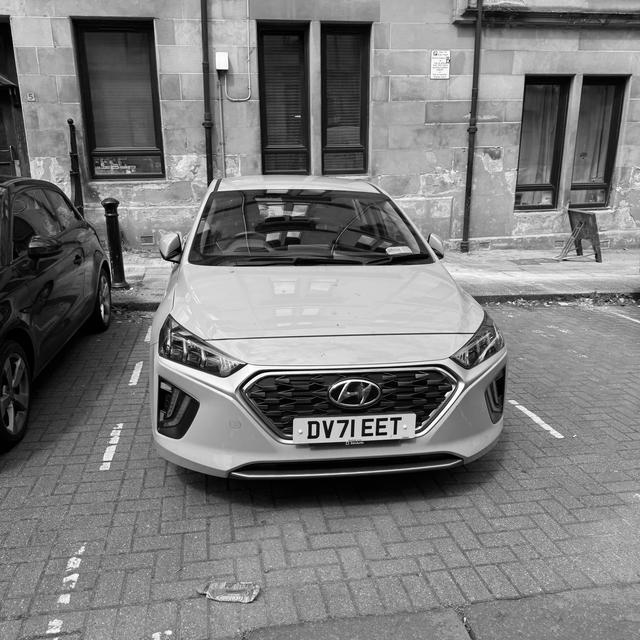

In [10]:
# img = cv2.imread('car.jpg')
image = cv2.imread(train_image_files[0])
img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2_imshow(img)


#Image Capture
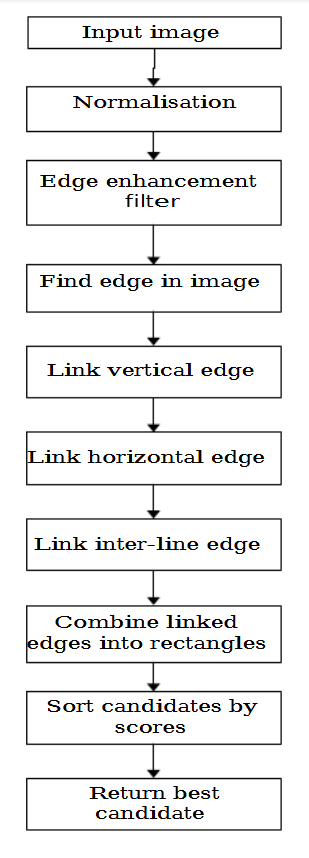

##Canny Edge

- normalise the images
- use one of the edge inhancers
- find contours
- isolate to a part of the image (lower half)
- determine the range of dimensions for a license plate and filter down further

#Comparing Edge Finding Abilities

In [11]:
def draw_plate(src, contours):
    license_plate_contour = None
    img_copy = src.copy()
    accepted_contours = [c for c in contours if is_license_plate_contour(c)]
    cv2.drawContours(img_copy,accepted_contours, -1, (0,255,0),2)
    return img_copy

def plot_the_plates(src, canny):
    num_rows = 1
    methods = ['Canny']
    fig, axes = plt.subplots(num_rows, 3)
    edges = [canny]

    # for row in range(num_rows):
    axes[0].imshow(cv2.cvtColor(src, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(edges[0], cmap='gray')
    axes[1].set_title(f'{methods[0]} Edges')
    axes[1].axis('off')
    contours = find_contours(edges[0])
    img_with_plate = draw_plate(src, contours)
    axes[2].imshow(cv2.cvtColor(img_with_plate, cv2.COLOR_BGR2RGB))
    axes[2].set_title(f'{methods[0]} with Contours')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


In [12]:
def is_license_plate_contour(contour):
    # Calculate the bounding box of the contour
    x, y, w, h = cv2.boundingRect(contour)
    # Calculate the area of the bounding box
    bounding_area = w*h
    contour_area = cv2.contourArea(contour)
    #  rectangulatiry check
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    # if len(approx) > 4:
    #   return False
    if not cv2.isContourConvex(approx):
      return False
    # Calculate aspect ratio
    # aspect_ratio = float(w) / h
    # if aspect_ratio < 2 or aspect_ratio > 6:
    #     return False
    if contour_area < 500 or contour_area > 6000:  # Adjust these thresholds based on the size of the image and expected license plate size
        return False
    # if contour[0][0][1] < 250: #
    #   return False
    # Limit Height
    # if h < 30:
    #   return False
    # Check for rectangularity
    # if contour_area < 0.6 * bounding_area:  # The contour area should be at least 80% of the bounding box area
    #     return False

    return True



In [13]:
def normalize_image(img):
  # Normalize image
  normalized_image = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
  return normalized_image

def get_canny_edges(img, thresh1=100, thresh2=200):
    # img_blur = cv2.GaussianBlur(img, (3, 3), 0)
    # img_blur =cv2.bilateralFilter(img, 11,17,17)
    canny_edged = cv2.Canny(img, 100, 200)
    return canny_edged

def find_contours(edges):
    if len(edges.shape) == 3:
        edges = cv2.cvtColor(edges, cv2.COLOR_BGR2GRAY)
    contours, _ = cv2.findContours(edges, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    # return contours
    contour_areas = [(cv2.contourArea(cnt), cnt) for cnt in contours]
    contour_areas.sort(key=lambda x: x[0], reverse=True)

# Get the top 10 largest contours
    top_10_contours = [cnt for _, cnt in contour_areas[:10]]
    # for cnt in top_10_contours:
      # print(cv2.contourArea(cnt))
    return top_10_contours

def licenesPlatePipeline(img):
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  eq_img = cv2.equalizeHist(gray_img)
  blurred = cv2.GaussianBlur(eq_img,(3,3), 0)
  threshed = cv2.threshold(blurred, 0,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
  edged = get_canny_edges(threshed, 50, 60)
  # cv2_imshow(edged)

  contours = find_contours(edged)
  accepted_contours = [c for c in contours if is_license_plate_contour(c)]
  bboxes = []
  for c in accepted_contours:
    x,y,w,h = cv2.boundingRect(c)
    bboxes.append(torch.tensor([x,y,x+w,y+h]))
  # img_copy = img.copy()
  # cv2.drawContours(img_copy,contours, -1, (0,255,0),2)
  # cv2_imshow(edged)
  # plt.imshow(img_copy)
  return bboxes

In [14]:
imgs = []
targets = []
for data in test_loader:
  for d in data:
    imgs.append(d[0])
    targ = {}
    targ['boxes'] = d[1]['boxes']
    targ['labels'] = d[1]['labels']
    targets.append(targ)



#Metric Testing Helper Functions

In [15]:
def build_df(iou_threshold=0.5):
  total_plates = 0
  col_names = ['Image', 'TP', 'FP', 'FN']
  df = pd.DataFrame(columns=col_names)

  for i, img in enumerate(imgs):
    bboxes = licenesPlatePipeline(img)
    true_boxes, true_classes = targets[i]['boxes'].cpu(), targets[i]['labels'].cpu()
    total_plates += torch.sum(true_classes == 2).item()
    for box in bboxes:
      iou = torchvision.ops.box_iou(box.reshape(1,4), true_boxes)
      matching_comp = torch.argmax(iou)
      if iou[0][matching_comp.item()].item() > iou_threshold:
        data_row = [f"Image {i}", 1, 0,0]
      elif iou[0][matching_comp.item()].item() ==0.0 :
        data_row = [f"Image {i}", 0, 0,1]
      else:
        data_row = [f"Image {i}", 0, 1,0]

      df.loc[len(df.index)] = data_row

  return total_plates, df

In [16]:
actual_plates, df = build_df()

In [17]:
print(df['FN'].sum())

33


In [18]:
def sort_df(df1):
  df1 = df1.sort_values(by=['TP'], ascending=False)
  df1.reset_index(inplace=True, drop=True)
  # car_df.drop('index', axis=1)

  # df2 = df2.sort_values(by=['TP'], ascending=False)
  # df2.reset_index(inplace=True,drop=True)
  # df2 = df2.drop([0,1])
  # df2.reset_index(inplace=True, drop=True)

  return df1

In [19]:
def PRCurve(df, total_detections):
  TP_acc = []
  FP_acc = []
  FN_acc = []
  Precision = []
  Recall = []
  f1 = []
  for index, row in df.iterrows():
    if index == 0:
      if row['TP'] == 1:
        TP_acc.append(1)
        FP_acc.append(0)
        FN_acc.append(0)
      elif row['FP'] == 1:
        TP_acc.append(0)
        FP_acc.append(1)
        FN_acc.append(0)
      elif row['FN'] == 1:
        TP_acc.append(0)
        FP_acc.append(0)
        FN_acc.append(1)
      Precision.append(TP_acc[-1]/(TP_acc[-1]+FP_acc[-1]))
      Recall.append(TP_acc[-1]/(total_detections))
      f1_score = 0 #2* (Precision[-1]*Recall[-1])/(Precision[-1]+Recall[-1])
      f1.append(f1_score)


    else:
      if row['TP'] == 1:
        TP_acc.append(TP_acc[index-1] + 1)
        FP_acc.append(FP_acc[-1])
        FN_acc.append(FN_acc[-1])
      elif row['FP'] == 1:
        TP_acc.append(TP_acc[index-1])
        FP_acc.append(FP_acc[-1] + 1)
        FN_acc.append(FN_acc[-1])
      elif row['FN'] == 1:
        TP_acc.append(TP_acc[index-1])
        FP_acc.append(FP_acc[-1])
        FN_acc.append(FN_acc[-1]+ 1)
      Precision.append(TP_acc[-1]/(TP_acc[-1]+FP_acc[-1]))
      Recall.append(TP_acc[-1]/(TP_acc[-1] + 78))
      f1_score = 2* (Precision[-1]*Recall[-1])/(Precision[-1]+Recall[-1])
      f1.append(f1_score)

  df['TP_acc'] = TP_acc
  df['FP_acc'] = FP_acc
  df['FN_acc'] = FN_acc
  df['Precision'] = Precision
  df["Recall"] = Recall
  df['F1'] = f1
  return df


In [21]:
thresholds = [round(i/100, 2) for i in range(50, 100, 5)]

# maps = []
# for i in range(len(thresholds)):
total_plates, df = build_df(thresholds[0])
plate_df = sort_df(df)
platePR = PRCurve(plate_df, total_plates)
auc_plate = auc(platePR['Recall'], platePR['Precision'])
print(auc_plate)
# maps.append(np.mean([ auc_plate]))

0.222473604826546


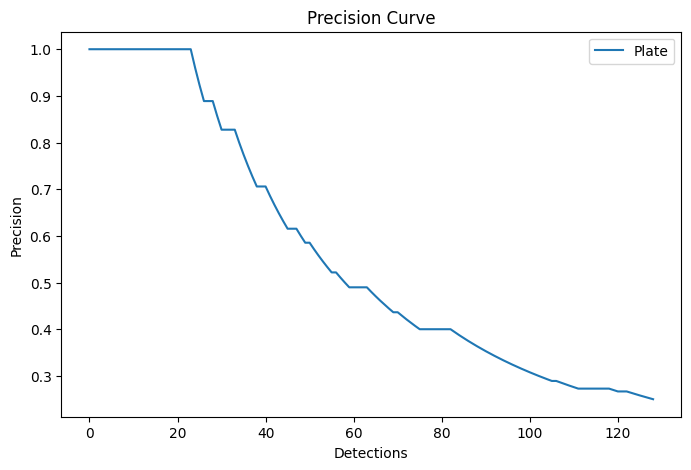

In [54]:
plt.figure(figsize = (8,5))
plt.plot(plate_df['Precision'])
plt.xlabel('Detections')
plt.ylabel('Precision')
plt.title(f'Precision Curve')
plt.legend(['Plate'])
plt.savefig('Precision.png')


plt.show()

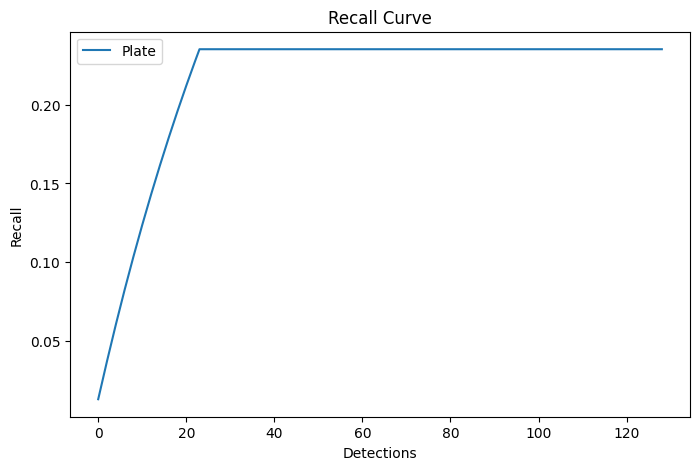

In [55]:
plt.figure(figsize = (8,5))
plt.plot(plate_df['Recall'])
plt.xlabel('Detections')
plt.ylabel('Recall')
plt.legend(['Plate'])

plt.title(f'Recall Curve')
plt.savefig('Recall.png')

plt.show()

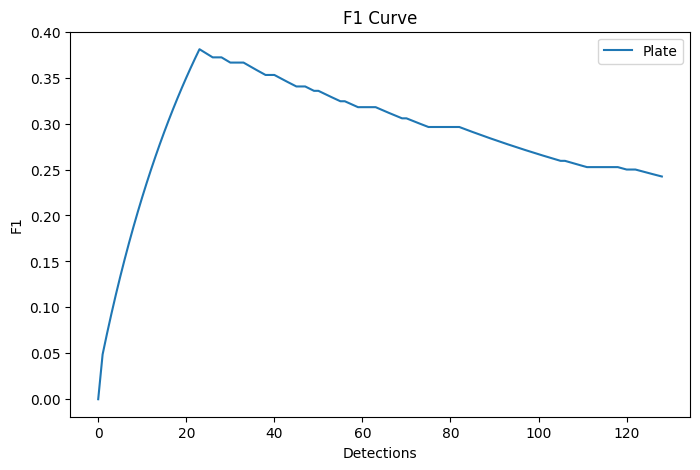

In [56]:
plt.figure(figsize = (8,5))
plt.plot(plate_df['F1'])
plt.xlabel('Detections')
plt.ylabel('F1')
plt.title(f'F1 Curve')
plt.legend(['Plate'])
plt.savefig('F1.png')

plt.show()

In [57]:
from sklearn.metrics import auc
def plot_PR_Curve(df, classStr):
  auc_pr = auc(df['Recall'], df['Precision'])
  plt.figure(figsize = (8,5))
  plt.plot(df['Recall'],df['Precision'])
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.legend(['Plate'])

  plt.title(f'Precision Recall Curve for {classStr}: AP = {auc_pr:.2f}')
  plt.xlim(min(df['Recall'])-0.02, 1)

  plt.grid(True)
  plt.legend(['Plate'])
  plt.savefig('PR_Curve.png')
  plt.show()

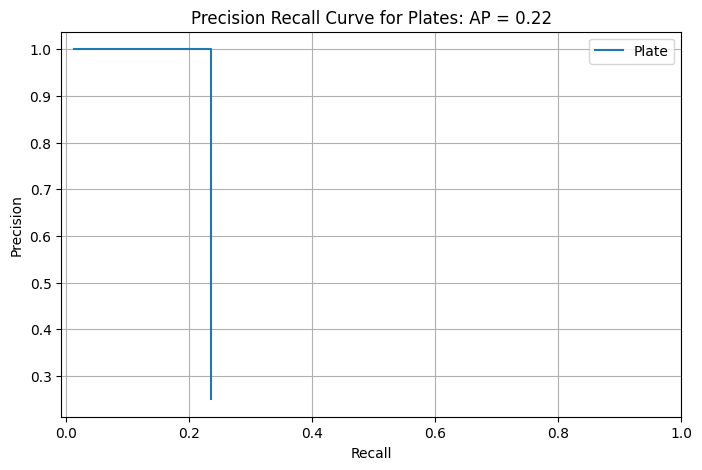

In [58]:
plot_PR_Curve(platePR, 'Plates')

In [25]:
plate_df

,Image,TP,FP,FN,TP_acc,FP_acc,FN_acc,Precision,Recall,F1
0,Image 29,1,0,0,1,0,0,1.000000,0.012821,0.000000
1,Image 47,1,0,0,2,0,0,1.000000,0.025000,0.048780
2,Image 24,1,0,0,3,0,0,1.000000,0.037037,0.071429
3,Image 24,1,0,0,4,0,0,1.000000,0.048780,0.093023
4,Image 48,1,0,0,5,0,0,1.000000,0.060241,0.113636
...,...,...,...,...,...,...,...,...,...,...
124,Image 30,0,1,0,24,68,33,0.260870,0.235294,0.247423
125,Image 29,0,1,0,24,69,33,0.258065,0.235294,0.246154
126,Image 29,0,1,0,24,70,33,0.255319,0.235294,0.244898
127,Image 29,0,1,0,24,71,33,0.252632,0.235294,0.243655


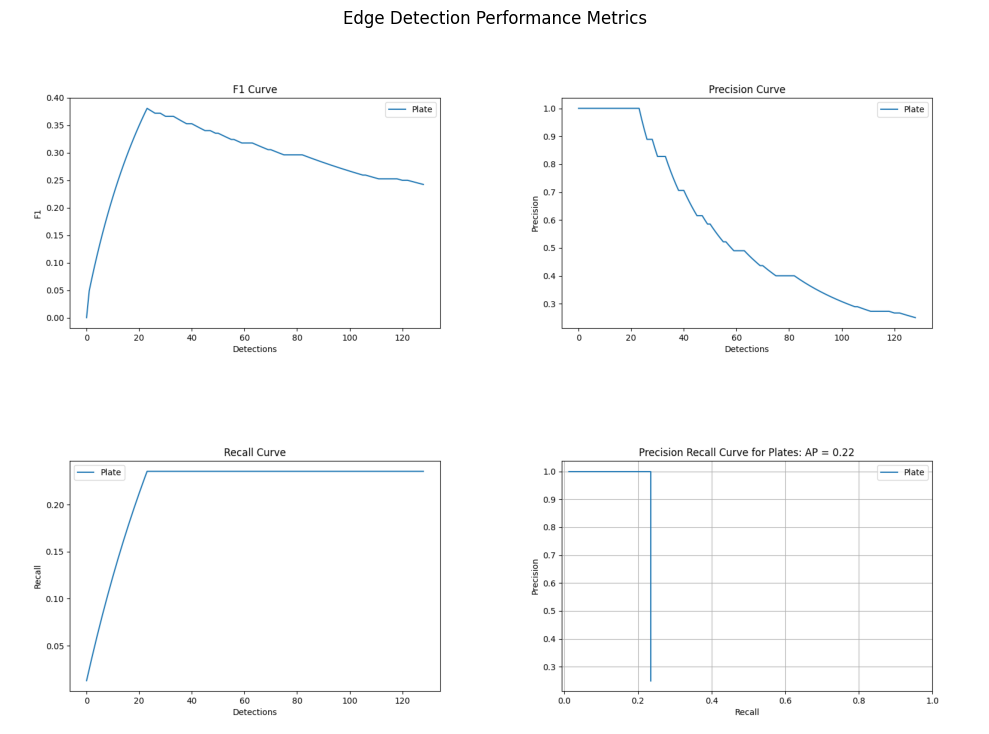

In [59]:
import matplotlib.image as mpimg

# File names of the images
image_files = ['/content/F1.png',
               '/content/Precision.png',
               '/content/Recall.png',
                '/content/PR_Curve.png']

# Load images
images = [mpimg.imread(image_file) for image_file in image_files]

# Create a 2x2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Plot each image
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.axis('off')  # Hide axes

# Adjust layout
plt.tight_layout()
plt.suptitle("Edge Detection Performance Metrics")
plt.show()

In [28]:
platePR.to_csv('/content/gdrive/My Drive/MSc Project/Comparison Data/Traditional_Model_Plate_Class_APRF.csv', index=False)

#Inference Times


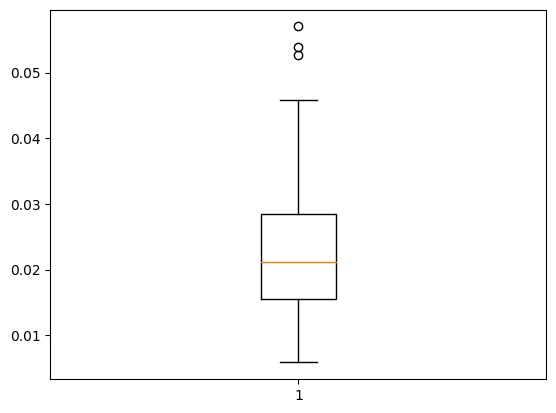

In [29]:
def get_inference_times():
  inference_times = []
  for i, img in enumerate(imgs):
    start_time = time.time()
    bboxes = licenesPlatePipeline(img)
    end_time = time.time()
    inference_times.append(end_time - start_time)
  return inference_times

inference_times = get_inference_times()
plt.boxplot(inference_times)
plt.show()

In [30]:
inf_times = pd.DataFrame(inference_times, columns=['Traditional_Model'])
inf_times.head()
inf_times.to_csv('/content/gdrive/My Drive/MSc Project/Comparison Data/Traditional_inference_times.csv', index=False)

#Data Spread

In [31]:
print(test_ann_df['category_id'].value_counts()[2])

78


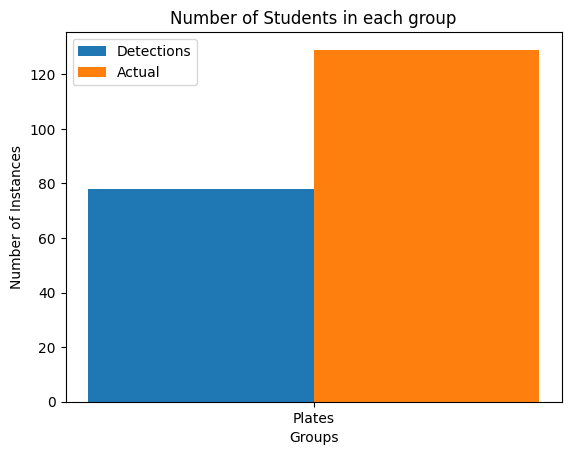

In [32]:
import numpy as np
import matplotlib.pyplot as plt

X = ['Plates']
detected = [total_plates]
labeled = [len(plate_df)]

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, detected, 0.4, label = 'Detections')
plt.bar(X_axis + 0.2, labeled, 0.4, label = 'Actual')

plt.xticks(X_axis, X)
plt.xlabel("Groups")
plt.ylabel("Number of Instances")
plt.title("Number of Students in each group")
plt.legend()
plt.show()

In [33]:
data = {
    'Actual Plates': [test_ann_df['category_id'].value_counts()[2]],
    'Predicted Plates': [len(plate_df)]}
data_spread_df = pd.DataFrame(data)
data_spread_df.head()
data_spread_df.to_csv('/content/gdrive/My Drive/MSc Project/Comparison Data/Traditional_Model_Data_Spread.csv', index=False)

#APRF

In [34]:
TP = platePR.iloc[-1]['TP_acc']
FN = platePR.iloc[-1]['FN_acc']
FP = platePR.iloc[-1]['FP_acc']

Precision = TP/(TP+FP)
Recall = TP/(TP+FN)
F1 = 2 * (Precision * Recall) / (Precision + Recall)
Accuracy = TP / test_ann_df['category_id'].value_counts()[2]

Precision, Recall, F1, Accuracy

(0.25, 0.42105263157894735, 0.3137254901960784, 0.3076923076923077)

#Unrelated, just getting some stuff for the report


Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


<Figure size 640x480 with 0 Axes>

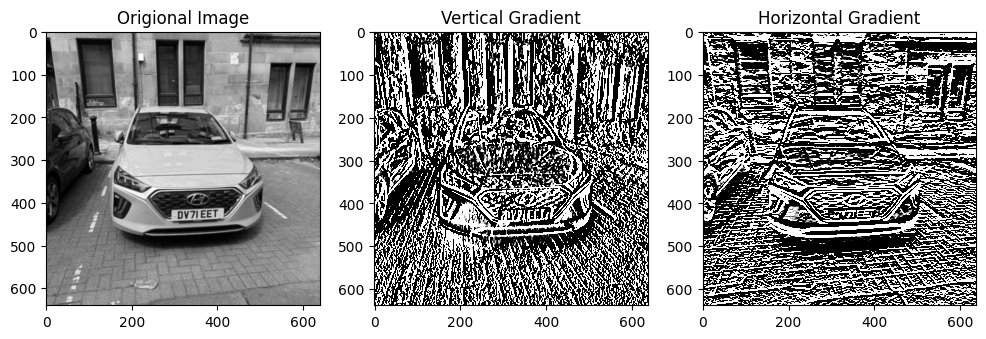

In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from imageio import imread
plt.set_cmap('gray')

img = imread(train_image_files[0])
img = cv2.GaussianBlur(img, (3, 3), 0)

# transform image to 2D for convenience (not necessary for convolution!)
img = np.mean(img,axis=2)
img = img/np.max(img)
# hand-craft two convolution kernels

# vertical kernel
VK = np.array([ [1,0,-1],
                [1,0,-1],
                [1,0,-1] ])

# horizontal kernel
HK = np.array([ [ 1, 1, 1],
                [ 0, 0, 0],
                [-1,-1,-1] ])

VK_t = torch.tensor(VK).view(1,1,3,3).double()
HK_t = torch.tensor(HK).view(1,1,3,3).double()
img_t = torch.tensor(img).view(1,1,img.shape[0],img.shape[1])

fig,ax = plt.subplots(1,3,figsize=(12,8))

ax[0].imshow(img, cmap=None)
ax[0].set_title('Origional Image')



# run convolution and show the result
convres = F.conv2d(img_t,VK_t)
img = torch.squeeze(convres.detach())
ax[1].imshow(img,cmap='gray',vmin=0,vmax=.01)
ax[1].set_title("Vertical Gradient")

convres = F.conv2d(img_t,HK_t)
img = torch.squeeze(convres.detach())
ax[2].imshow(img,cmap='gray',vmin=0,vmax=.01)
ax[2].set_title('Horizontal Gradient')
plt.show()



